# The Battle of Neighborhoods

#### Import and downloads the libraries

In [2]:
# !pip install geopy
!pip install geocoder
!pip install folium
import pandas as pd
import numpy as np
import json
import requests
import folium
import geocoder
import csv
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


#### Get the location in London

In [3]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_areas_of_London').text

In [4]:
soup = BeautifulSoup(source,'lxml')
wiki_table=soup.find(class_='wikitable sortable')
#develop dataframe
df = pd.read_html(str(wiki_table))[0]
df.columns=['Neighbourhood', 'Borough', 'PostCode', 'District', 'Dial', 'OSRef']
df.drop(['Dial', 'OSRef'], axis=1, inplace=True)
df.head()

,Neighbourhood,Borough,PostCode,District
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4"
2,Addington,Croydon[8],CROYDON,CR0
3,Addiscombe,Croydon[8],CROYDON,CR0
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14"


#### Combine the dataframe with longitude and latitude

In [5]:
latitude = []
longitude = []
lat_lon_coords = None

neighbour = df['Neighbourhood']
for n in neighbour:
    g = geocoder.arcgis('{}, London, UK'.format(n))
    lat_lon_coords = g.latlng
    latitude.append(lat_lon_coords[0])
    longitude.append(lat_lon_coords[1])

london = df
london['Latitude'] = latitude
london['Longitude'] = longitude

london.head()

,Neighbourhood,Borough,PostCode,District,Latitude,Longitude
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,51.490860,0.121020
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",51.633296,-0.176466
2,Addington,Croydon[8],CROYDON,CR0,51.575810,-0.109340
3,Addiscombe,Croydon[8],CROYDON,CR0,51.472749,-0.203326
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",51.485820,-0.080260


In [6]:
london.shape

(531, 6)

#### FourSquare Credentials Part

In [7]:
CLIENT_ID = 'FIM0P3VXHHJ3LVL04HBTMJUVJUAIPHWO0VOZHQEATFDYCESU'
CLIENT_SECRET = 'IUTUYYAUTRI30HCOCHNVS4NBKPNYCA2UTIJ5CYQPMPQF4YAC'
VERSION = '20180605'

print('Your credentails: ')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET: ' + CLIENT_SECRET)

Your credentails: 
CLIENT_ID: FIM0P3VXHHJ3LVL04HBTMJUVJUAIPHWO0VOZHQEATFDYCESU
CLIENT_SECRET: IUTUYYAUTRI30HCOCHNVS4NBKPNYCA2UTIJ5CYQPMPQF4YAC


#### London Longitude and Latitude

In [8]:
address = 'London, UK'
geolocator = Nominatim(user_agent='ld_explorer')
location = geolocator.geocode(address)
lat_london = location.latitude
lon_london = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(lat_london, lon_london))

The geograpical coordinate of London are 51.5073219, -0.1276474.


#### Plot the map of London

In [9]:
lon_map = folium.Map(location=[lat_london, lon_london], zoom_start=10)

for lat, lon, label in zip(london['Latitude'], london['Longitude'], london['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius = 3,
        popup = label,
        color = '#2E86C1',
        fill = True,
        fill_color = '#48C9B0',
        fill_opacity = 0.7,
        parse_html = False
    ).add_to(lon_map)
    
lon_map

#### Create a function which will extract the category from the FourSquare venues

In [10]:
def get_category_type(row):
    categories_list = row['Category']
    
    if len(categories_list) == 0:
        return None
    else: 
        return categories_list[0]['name']

In [11]:
explore_df_list = []

for i, neibour_name in enumerate(london['Neighbourhood']):
    try:
        neibour_name = london.loc[i, 'Neighbourhood']
        neibour_lat = london.loc[i, 'Latitude']
        neibour_lon = london.loc[i, 'Longitude']
        radius = 1500
        LIMIT = 50
        
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neibour_lat, neibour_lon, VERSION, radius, LIMIT)
        
        results = json.loads(requests.get(url).text)
        # print(results)
        results = results['response']['groups'][0]['items']
        nearby = json_normalize(results)
        # print(nearby)
        filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
        nearby = nearby.loc[:, filtered_columns]
        # print(nearby)
        columns = ['Name', 'Category', 'Latitude', 'Longitude']
        nearby.columns = columns
        nearby['Category'] = nearby.apply(get_category_type, axis=1)
        
        for i, n in enumerate(nearby['Name']):
            s_list = nearby.loc[i, :].values.tolist()
            f_list = [neibour_name, neibour_lat, neibour_lon] + s_list
            explore_df_list.append(f_list)
        
    except Exception as e:
        pass
    


/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:16: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


In [12]:
# explore_df_list

#### Create the dataframe for clustering

In [13]:
explore_lon = pd.DataFrame([item for item in explore_df_list])
explore_lon.columns = ['Neighbourhood', 'NeighbourLatitude', 'NeighbourLongitude', 'VenueName', 'VenueCategory', 'VenueLatitude', 'VenueLongitude']
explore_lon.head()

,Neighbourhood,NeighbourLatitude,NeighbourLongitude,VenueName,VenueCategory,VenueLatitude,VenueLongitude
0,Abbey Wood,51.49086,0.12102,Lesnes Abbey,Historic Site,51.489526,0.125839
1,Abbey Wood,51.49086,0.12102,Sainsbury's,Supermarket,51.492826,0.120524
2,Abbey Wood,51.49086,0.12102,Lidl,Supermarket,51.496152,0.118417
3,Abbey Wood,51.49086,0.12102,Co-op Food,Grocery Store,51.487490,0.113751
4,Abbey Wood,51.49086,0.12102,Tattoo-Shirts,Accessories Store,51.495259,0.110575


#### Hotspot counting near the neighbourhoods of London

In [14]:
lon_hotspot = pd.get_dummies(explore_lon['VenueCategory'], prefix='', prefix_sep='')
lon_hotspot['Neighbourhood'] = explore_lon['Neighbourhood']
columns = [lon_hotspot.columns[-1]] + lon_hotspot.columns[:-1].values.tolist()
lon_hotspot = lon_hotspot[columns]

lon_hotspot.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,Airport Ticket Counter,American Restaurant,...,Windmill,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Abbey Wood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Abbey Wood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Abbey Wood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Abbey Wood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Abbey Wood,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Aggregate the venues by Neighourhoods

In [15]:
london_group = lon_hotspot.groupby('Neighbourhood').mean().reset_index()
london_group.head(10)

,Neighbourhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,Airport Ticket Counter,American Restaurant,...,Windmill,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Abbey Wood,0.1,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0
1,Acton,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0
2,Addington,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.02,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0
3,Addiscombe,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.02,0.0,0.0,0.0,0.00,0.04,0.0,0.0
4,Albany Park,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.02,0.0,0.0,0.0,0.02,0.00,0.0,0.0
5,Aldborough Hatch,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0
6,Aldgate,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0
7,Aldwych,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.02,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0
8,Alperton,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.02,0.00,0.0,0.0,0.0,0.00,0.02,0.0,0.0
9,Anerley,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0


#### Function for most common venues

In [16]:
def most_common_venue(row, top_venue):
    category = row.iloc[1:]
    category_sorted = category.sort_values(ascending=False)
    return category_sorted.index.values[0:top_venue]

#### Top 10 venues for each Location(Neighbourhood)

In [17]:
top_venue = 10
columns = ['Neighbourhood']
for index in np.arange(top_venue):
    columns.append('Top {} Common Venue'.format(index+1))

neighbour_venue = pd.DataFrame(columns=columns)
neighbour_venue['Neighbourhood'] = london_group['Neighbourhood']

for index in np.arange(london_group.shape[0]):
    neighbour_venue.iloc[index, 1:] = most_common_venue(london_group.iloc[index, :], top_venue)
    
neighbour_venue.head(10)

,Neighbourhood,Top 1 Common Venue,Top 2 Common Venue,Top 3 Common Venue,Top 4 Common Venue,Top 5 Common Venue,Top 6 Common Venue,Top 7 Common Venue,Top 8 Common Venue,Top 9 Common Venue,Top 10 Common Venue
0,Abbey Wood,Supermarket,Accessories Store,Historic Site,Soccer Field,Lake,Pub,Indian Restaurant,Grocery Store,Forest,Farm
1,Acton,Coffee Shop,Pub,Café,Fish & Chips Shop,Grocery Store,Park,Italian Restaurant,Supermarket,Asian Restaurant,Golf Course
2,Addington,Turkish Restaurant,Café,Pub,Coffee Shop,Pizza Place,Italian Restaurant,Bakery,Restaurant,Park,Organic Grocery
3,Addiscombe,Café,Park,Pub,Coffee Shop,Yoga Studio,Grocery Store,Fish & Chips Shop,Pizza Place,Bakery,Italian Restaurant
4,Albany Park,Coffee Shop,Italian Restaurant,Brewery,Beer Bar,Café,Pub,Park,Plaza,Bike Shop,Breakfast Spot
5,Aldborough Hatch,Supermarket,Playground,Café,Metro Station,Park,Steakhouse,Social Club,Soccer Field,Golf Course,Pet Store
6,Aldgate,Hotel,Cocktail Bar,Coffee Shop,Gym / Fitness Center,Pizza Place,Market,Castle,Scenic Lookout,Sushi Restaurant,Event Space
7,Aldwych,Hotel,Steakhouse,Ice Cream Shop,Sushi Restaurant,Bakery,Theater,Restaurant,History Museum,Coffee Shop,Spanish Restaurant
8,Alperton,Pub,Pizza Place,Bakery,Café,Italian Restaurant,Restaurant,Coffee Shop,Cocktail Bar,Movie Theater,Gym
9,Anerley,Pub,Italian Restaurant,Café,Gastropub,Pizza Place,Supermarket,Garden Center,Garden,Grocery Store,Bike Shop


#### Apply K-Means clustering

In [18]:
london_group_clustering = london_group.drop('Neighbourhood', 1)

In [19]:
%matplotlib inline
def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20, 10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

In [20]:
from sklearn.metrics import silhouette_samples, silhouette_score
max_range = 20
indices = []
scores = []

for lon_clusters in range (2, max_range):
    lon_gc = london_group_clustering
    kmeans = KMeans(n_clusters=lon_clusters, init='k-means++', random_state=0).fit_predict(lon_gc)
    score = silhouette_score(lon_gc, kmeans)
    indices.append(lon_clusters)
    scores.append(score)

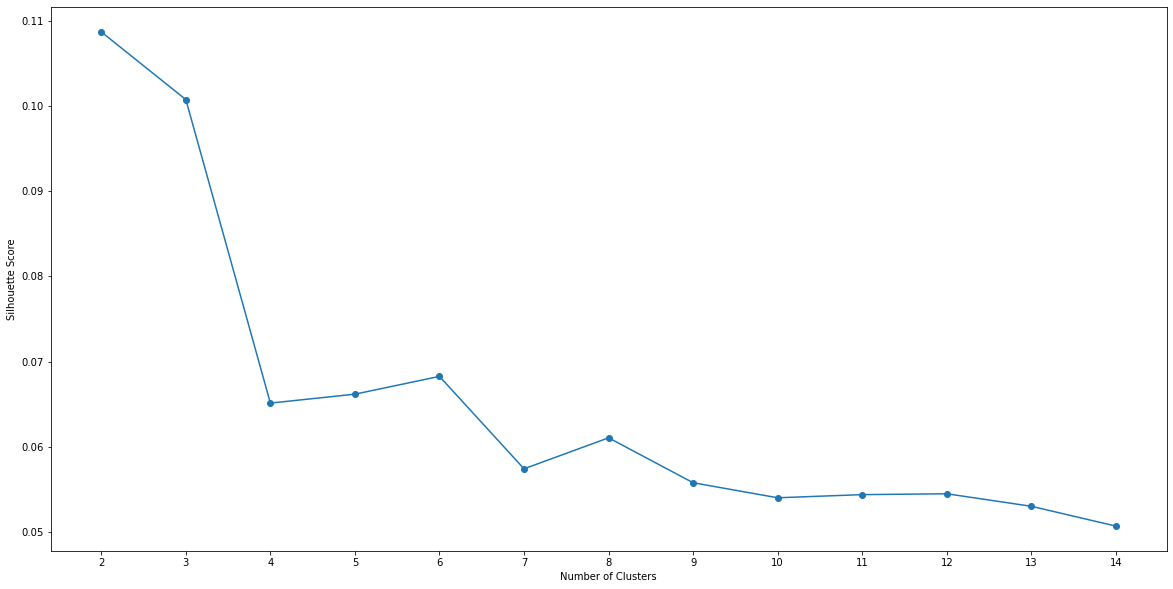

In [21]:
plot(max_range, scores, 'Number of Clusters', 'Silhouette Score')

#### According to the raph, the K should be 14 for Elbow Method

In [22]:
opt_value = 14

#### Calculate optimum value of cluster, and proceed K-Means clustering

In [23]:
lon_clusters = opt_value
lon_gc = london_group_clustering
kmeans = KMeans(n_clusters = lon_clusters, init='k-means++', random_state=0).fit(lon_gc)
neighbour_venue.insert(0, 'Cluster Label', kmeans.labels_)

#### Final dataframe version conatining all the necessary data

In [44]:
london_final = london
london_final = london_final.join(neighbour_venue.set_index('Neighbourhood'), on='Neighbourhood')
london_final.dropna(inplace=True)
london_final['Cluster Label'] = london_final['Cluster Label'].astype(int)
london_final

,Neighbourhood,Borough,PostCode,District,Latitude,Longitude,Cluster Label,Top 1 Common Venue,Top 2 Common Venue,Top 3 Common Venue,Top 4 Common Venue,Top 5 Common Venue,Top 6 Common Venue,Top 7 Common Venue,Top 8 Common Venue,Top 9 Common Venue,Top 10 Common Venue
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,51.490860,0.121020,6,Supermarket,Accessories Store,Historic Site,Soccer Field,Lake,Pub,Indian Restaurant,Grocery Store,Forest,Farm
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",51.633296,-0.176466,9,Coffee Shop,Pub,Café,Fish & Chips Shop,Grocery Store,Park,Italian Restaurant,Supermarket,Asian Restaurant,Golf Course
2,Addington,Croydon[8],CROYDON,CR0,51.575810,-0.109340,4,Turkish Restaurant,Café,Pub,Coffee Shop,Pizza Place,Italian Restaurant,Bakery,Restaurant,Park,Organic Grocery
3,Addiscombe,Croydon[8],CROYDON,CR0,51.472749,-0.203326,0,Café,Park,Pub,Coffee Shop,Yoga Studio,Grocery Store,Fish & Chips Shop,Pizza Place,Bakery,Italian Restaurant
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",51.485820,-0.080260,9,Coffee Shop,Italian Restaurant,Brewery,Beer Bar,Café,Pub,Park,Plaza,Bike Shop,Breakfast Spot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,Woolwich,Greenwich,LONDON,SE18,51.630800,-0.127810,3,Pub,Park,Gym / Fitness Center,Grocery Store,Playground,Pizza Place,Coffee Shop,Fast Food Restaurant,Café,Italian Restaurant
527,Worcester Park,"Sutton, Kingston upon Thames",WORCESTER PARK,KT4,51.371000,-0.228085,7,Pub,Grocery Store,Coffee Shop,Supermarket,Café,Park,Indian Restaurant,Bus Stop,Pizza Place,Fast Food Restaurant
528,Wormwood Scrubs,Hammersmith and Fulham,LONDON,W12,51.518420,-0.237130,12,Park,Gym / Fitness Center,Indian Restaurant,Café,Portuguese Restaurant,Gastropub,Modern European Restaurant,Grocery Store,Pizza Place,Middle Eastern Restaurant
529,Yeading,Hillingdon,HAYES,UB4,51.544586,-0.057511,5,Pub,Brewery,Bakery,Café,Coffee Shop,Modern European Restaurant,Butcher,Pizza Place,Vegetarian / Vegan Restaurant,Restaurant


#### Use Folium visualizing the cluster

In [25]:
map_clusters = folium.Map(location=[lat_london, lon_london], zoom_start=10)

x = np.arange(lon_clusters)
ys = [i + x + (i*x)**2 for i in range(lon_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []

for lat, lon, poi, cluster in zip(london_final['Latitude'], london_final['Longitude'], london_final['Neighbourhood'], london_final['Cluster Label']):
    label = folium.Popup(str(poi) + '(Label' + str(cluster+1) + ')', parse_html=True)
    map_clusters.add_child(
        folium.features.CircleMarker(
            [lat, lon],
            radius = 3,
            popup = label,
            color = rainbow[cluster-1],
            fill = True,
            fill_color = rainbow[cluster-1],
            fill_opacity = 0.7,
        )
    )
    
map_clusters

In [29]:
val = 1
london_final.loc[london_final['Cluster Label'] == (val-1), london_final.columns[[0] + np.arange(7, london_final.shape[1]).tolist()]]

,Neighbourhood,Top 1 Common Venue,Top 2 Common Venue,Top 3 Common Venue,Top 4 Common Venue,Top 5 Common Venue,Top 6 Common Venue,Top 7 Common Venue,Top 8 Common Venue,Top 9 Common Venue,Top 10 Common Venue
3,Addiscombe,Café,Park,Pub,Coffee Shop,Yoga Studio,Grocery Store,Fish & Chips Shop,Pizza Place,Bakery,Italian Restaurant
33,Beddington,Café,Coffee Shop,Pub,Italian Restaurant,Park,Indian Restaurant,Gym / Fitness Center,Gastropub,Forest,Cheese Shop
39,Belsize Park,Café,Bookstore,Bakery,Museum,Gym / Fitness Center,Pizza Place,Coffee Shop,Movie Theater,Deli / Bodega,Hotel Bar
43,Bethnal Green,Café,Pub,Coffee Shop,Cocktail Bar,Bagel Shop,Bakery,Market,Beer Bar,Bookstore,Bar
72,Burnt Oak,Café,Pub,Coffee Shop,Market,Beer Store,Bookstore,Gastropub,Bakery,Yoga Studio,Deli / Bodega
75,Cambridge Heath,Coffee Shop,Café,Pub,Cocktail Bar,Beer Bar,Bookstore,Hotel,Bakery,Pizza Place,Yoga Studio
79,Canning Town,Pub,Coffee Shop,French Restaurant,Café,Market,Flea Market,Gastropub,Beer Store,Ice Cream Shop,Yoga Studio
86,Chalk Farm,Coffee Shop,Café,Pub,Market,Bar,Flea Market,Park,Outdoor Sculpture,Beer Store,Yoga Studio
108,Colney Hatch,Café,Coffee Shop,Pub,Grocery Store,Garden Center,Gym / Fitness Center,Bakery,Japanese Restaurant,Deli / Bodega,Organic Grocery
134,Denmark Hill,Café,Park,Coffee Shop,Pub,Gastropub,Bar,Gym / Fitness Center,Indian Restaurant,Beer Bar,Grocery Store


In [30]:
val = 2
london_final.loc[london_final['Cluster Label'] == (val-1), london_final.columns[[0] + np.arange(7, london_final.shape[1]).tolist()]]

,Neighbourhood,Top 1 Common Venue,Top 2 Common Venue,Top 3 Common Venue,Top 4 Common Venue,Top 5 Common Venue,Top 6 Common Venue,Top 7 Common Venue,Top 8 Common Venue,Top 9 Common Venue,Top 10 Common Venue
6,Aldgate,Hotel,Cocktail Bar,Coffee Shop,Gym / Fitness Center,Pizza Place,Market,Castle,Scenic Lookout,Sushi Restaurant,Event Space
7,Aldwych,Hotel,Steakhouse,Ice Cream Shop,Sushi Restaurant,Bakery,Theater,Restaurant,History Museum,Coffee Shop,Spanish Restaurant
17,Bankside,Coffee Shop,Italian Restaurant,Hotel,Seafood Restaurant,Art Museum,Restaurant,Burger Joint,Grocery Store,Portuguese Restaurant,Wine Bar
18,Barbican,Coffee Shop,Food Truck,Gym / Fitness Center,Hotel,Steakhouse,Bar,Concert Hall,Roof Deck,Vietnamese Restaurant,Cocktail Bar
28,Bayswater,Hotel,Coffee Shop,Gym / Fitness Center,Garden,Gastropub,American Restaurant,Café,Hotel Bar,Pub,Fountain
...,...,...,...,...,...,...,...,...,...,...,...
467,Tower Hill,Hotel,Coffee Shop,Cocktail Bar,Gym / Fitness Center,Scenic Lookout,Restaurant,Garden,Castle,Tapas Restaurant,Grocery Store
473,Upminster Bridge,Hotel,Cocktail Bar,Coffee Shop,Steakhouse,Scenic Lookout,Restaurant,Gym / Fitness Center,Castle,Event Space,Trail
494,Wembley,Indian Restaurant,Coffee Shop,Clothing Store,Hotel,Pharmacy,Gym / Fitness Center,Sporting Goods Shop,Sandwich Place,Pizza Place,Ice Cream Shop
495,Wembley Park,Coffee Shop,Hotel,Clothing Store,Indian Restaurant,Gym / Fitness Center,Sporting Goods Shop,Grocery Store,Bar,Pedestrian Plaza,Park


In [31]:
val = 3
london_final.loc[london_final['Cluster Label'] == (val-1), london_final.columns[[0] + np.arange(7, london_final.shape[1]).tolist()]]

,Neighbourhood,Top 1 Common Venue,Top 2 Common Venue,Top 3 Common Venue,Top 4 Common Venue,Top 5 Common Venue,Top 6 Common Venue,Top 7 Common Venue,Top 8 Common Venue,Top 9 Common Venue,Top 10 Common Venue
15,Arnos Grove,Grocery Store,Pub,Café,Gym / Fitness Center,Park,Pharmacy,Supermarket,Turkish Restaurant,Coffee Shop,Italian Restaurant
31,Becontree,Pub,Grocery Store,Café,Restaurant,Park,Coffee Shop,Pizza Place,Bakery,Mediterranean Restaurant,Fast Food Restaurant
32,Becontree Heath,Pub,Grocery Store,Café,Restaurant,Park,Coffee Shop,Pizza Place,Bakery,Mediterranean Restaurant,Fast Food Restaurant
47,Biggin Hill,Pub,Café,Park,Grocery Store,Supermarket,Fish & Chips Shop,Garden,Steakhouse,Breakfast Spot,Sporting Goods Shop
53,Blendon,Grocery Store,Pub,Coffee Shop,Bakery,Clothing Store,Supermarket,Fast Food Restaurant,Pharmacy,Plaza,Park
56,Bounds Green,Grocery Store,Pub,Coffee Shop,Park,Greek Restaurant,Bus Stop,Bakery,Café,Gourmet Shop,Indie Theater
78,Cann Hall,Pub,Grocery Store,Café,Coffee Shop,Park,Restaurant,Bakery,Italian Restaurant,Dim Sum Restaurant,Thai Restaurant
81,Carshalton,Pub,Park,Grocery Store,Café,Gym / Fitness Center,Platform,Turkish Restaurant,Coffee Shop,Supermarket,Veterinarian
104,Cockfosters,Grocery Store,Soccer Field,Pub,Golf Course,Zoo Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
109,Colyers,Café,Pub,Grocery Store,Supermarket,Bar,Gastropub,Gym / Fitness Center,Coffee Shop,Pizza Place,Park


In [32]:
val = 4
london_final.loc[london_final['Cluster Label'] == (val-1), london_final.columns[[0] + np.arange(7, london_final.shape[1]).tolist()]]

,Neighbourhood,Top 1 Common Venue,Top 2 Common Venue,Top 3 Common Venue,Top 4 Common Venue,Top 5 Common Venue,Top 6 Common Venue,Top 7 Common Venue,Top 8 Common Venue,Top 9 Common Venue,Top 10 Common Venue
48,Blackfen,Pub,Brewery,Art Gallery,Italian Restaurant,Gym / Fitness Center,Park,Beer Bar,Bar,Bakery,Indie Movie Theater
51,Blackheath Royal Standard,Pub,Garden,Park,Historic Site,Restaurant,Furniture / Home Store,Coffee Shop,Planetarium,Observatory,Outdoor Sculpture
58,Bowes Park,Pub,Grocery Store,Greek Restaurant,Coffee Shop,Turkish Restaurant,Park,Golf Course,Fast Food Restaurant,Café,Pharmacy
62,Brimsdown,Pub,Park,Café,Grocery Store,Bar,Coffee Shop,Convenience Store,Supermarket,Gym,English Restaurant
70,Brunswick Park,Coffee Shop,Pub,Park,Furniture / Home Store,Bar,Turkish Restaurant,Bakery,Nightclub,Café,Gym
111,Coombe,Turkish Restaurant,Park,Pub,Indian Restaurant,Mediterranean Restaurant,Greek Restaurant,Bar,Bakery,Italian Restaurant,Hookah Bar
112,Coombe,Turkish Restaurant,Park,Pub,Indian Restaurant,Mediterranean Restaurant,Greek Restaurant,Bar,Bakery,Italian Restaurant,Hookah Bar
120,Crews Hill,Park,Pub,Bar,Vietnamese Restaurant,Sandwich Place,Farm,Supermarket,Coffee Shop,Trail,Italian Restaurant
126,Croydon,Pub,Park,Coffee Shop,Grocery Store,Turkish Restaurant,Café,Italian Restaurant,Lounge,Gym / Fitness Center,Fast Food Restaurant
128,Cubitt Town,Pub,Bar,Park,Hotel,Brewery,Coffee Shop,Sandwich Place,Turkish Restaurant,Street Food Gathering,Lounge


In [33]:
val = 5
london_final.loc[london_final['Cluster Label'] == (val-1), london_final.columns[[0] + np.arange(7, london_final.shape[1]).tolist()]]

,Neighbourhood,Top 1 Common Venue,Top 2 Common Venue,Top 3 Common Venue,Top 4 Common Venue,Top 5 Common Venue,Top 6 Common Venue,Top 7 Common Venue,Top 8 Common Venue,Top 9 Common Venue,Top 10 Common Venue
2,Addington,Turkish Restaurant,Café,Pub,Coffee Shop,Pizza Place,Italian Restaurant,Bakery,Restaurant,Park,Organic Grocery
98,Chislehurst,Turkish Restaurant,Café,Supermarket,Coffee Shop,Park,Sushi Restaurant,Japanese Restaurant,Gym / Fitness Center,Indian Restaurant,Portuguese Restaurant
171,Finsbury,Turkish Restaurant,Café,Coffee Shop,Park,Italian Restaurant,Pub,Pizza Place,Bakery,Trail,Organic Grocery
223,Harringay,Turkish Restaurant,Pub,Café,Coffee Shop,Bakery,Organic Grocery,Park,Pizza Place,Restaurant,Gym / Fitness Center
249,Hornsey,Turkish Restaurant,Café,Pub,Mediterranean Restaurant,Bakery,Coffee Shop,Italian Restaurant,Thai Restaurant,Bookstore,Brewery
264,Keston,Turkish Restaurant,Pub,Café,Park,Italian Restaurant,Coffee Shop,Lounge,Bakery,Tapas Restaurant,Bookstore
319,New Addington,Turkish Restaurant,Café,Pub,Coffee Shop,Pizza Place,Italian Restaurant,Bakery,Restaurant,Park,Organic Grocery
411,South Hackney,Turkish Restaurant,Café,Pub,Park,Bakery,Coffee Shop,Organic Grocery,Pizza Place,Grocery Store,Trail
419,South Tottenham,Turkish Restaurant,Café,Pub,Park,Bakery,Coffee Shop,Pizza Place,Organic Grocery,Gym / Fitness Center,Grocery Store
437,Stanmore,Turkish Restaurant,Café,Pub,Park,Bakery,Mediterranean Restaurant,Coffee Shop,Hookah Bar,Furniture / Home Store,Bar


In [34]:
val = 6
london_final.loc[london_final['Cluster Label'] == (val-1), london_final.columns[[0] + np.arange(7, london_final.shape[1]).tolist()]]

,Neighbourhood,Top 1 Common Venue,Top 2 Common Venue,Top 3 Common Venue,Top 4 Common Venue,Top 5 Common Venue,Top 6 Common Venue,Top 7 Common Venue,Top 8 Common Venue,Top 9 Common Venue,Top 10 Common Venue
8,Alperton,Pub,Pizza Place,Bakery,Café,Italian Restaurant,Restaurant,Coffee Shop,Cocktail Bar,Movie Theater,Gym
9,Anerley,Pub,Italian Restaurant,Café,Gastropub,Pizza Place,Supermarket,Garden Center,Garden,Grocery Store,Bike Shop
13,Ardleigh Green,Pub,Café,Pizza Place,Coffee Shop,Cocktail Bar,Park,Italian Restaurant,Fruit & Vegetable Store,Theater,Middle Eastern Restaurant
14,Arkley,Pub,Coffee Shop,Restaurant,Café,Pizza Place,Tea Room,Supermarket,Italian Restaurant,Burger Joint,Bar
34,Bedford Park,Pub,Café,Coffee Shop,Pizza Place,Tea Room,Turkish Restaurant,Restaurant,Brewery,Gym / Fitness Center,Art Gallery
46,Bickley,Pub,Restaurant,Coffee Shop,Brewery,Hotel,Supermarket,Café,Burger Joint,Bakery,Tea Room
90,Cheam,Pub,Park,Italian Restaurant,Cocktail Bar,Coffee Shop,Bar,Pizza Place,Restaurant,Community Center,Sake Bar
110,Coney Hall,Pub,Café,Pizza Place,Restaurant,Coffee Shop,Tea Room,Turkish Restaurant,Brewery,Vegetarian / Vegan Restaurant,Art Gallery
132,Dalston,Pub,Café,Cocktail Bar,Bar,Modern European Restaurant,Turkish Restaurant,Coffee Shop,Pizza Place,Yoga Studio,Brewery
133,De Beauvoir Town,Pub,Coffee Shop,Italian Restaurant,Gastropub,Canal,Cocktail Bar,Bakery,Park,Trail,Movie Theater


In [35]:
val = 7
london_final.loc[london_final['Cluster Label'] == (val-1), london_final.columns[[0] + np.arange(7, london_final.shape[1]).tolist()]]

,Neighbourhood,Top 1 Common Venue,Top 2 Common Venue,Top 3 Common Venue,Top 4 Common Venue,Top 5 Common Venue,Top 6 Common Venue,Top 7 Common Venue,Top 8 Common Venue,Top 9 Common Venue,Top 10 Common Venue
0,Abbey Wood,Supermarket,Accessories Store,Historic Site,Soccer Field,Lake,Pub,Indian Restaurant,Grocery Store,Forest,Farm
5,Aldborough Hatch,Supermarket,Playground,Café,Metro Station,Park,Steakhouse,Social Club,Soccer Field,Golf Course,Pet Store
19,Barking,Supermarket,Indian Restaurant,Hotel,Coffee Shop,Fast Food Restaurant,Grocery Store,Furniture / Home Store,Discount Store,Park,Sandwich Place
20,Barkingside,Supermarket,Pub,Sporting Goods Shop,Fast Food Restaurant,Indian Restaurant,Pizza Place,Farmers Market,Pet Store,Clothing Store,Pharmacy
42,Berrylands,Grocery Store,Pub,Coffee Shop,Park,Supermarket,Fast Food Restaurant,Hardware Store,Café,Korean Restaurant,Playground
61,Brent Park,Grocery Store,Portuguese Restaurant,Scandinavian Restaurant,Supermarket,Fast Food Restaurant,Warehouse Store,Bar,Indian Restaurant,Bus Stop,Thai Restaurant
66,Bromley (also Bromley-by-Bow),Supermarket,Grocery Store,Coffee Shop,Park,Fast Food Restaurant,Italian Restaurant,Café,Pub,Japanese Restaurant,Turkish Restaurant
85,Chadwell Heath,Supermarket,Grocery Store,Indian Restaurant,Park,Gym / Fitness Center,Golf Course,Mini Golf,Sports Club,English Restaurant,Electronics Store
88,Charlton,Clothing Store,Pub,Supermarket,Park,Grocery Store,Coffee Shop,Gym / Fitness Center,Furniture / Home Store,Fast Food Restaurant,Thai Restaurant
105,Colindale,Supermarket,Pub,Gym / Fitness Center,Park,Sandwich Place,Grocery Store,Asian Restaurant,History Museum,Fast Food Restaurant,Hookah Bar


In [36]:
val = 8
london_final.loc[london_final['Cluster Label'] == (val-1), london_final.columns[[0] + np.arange(7, london_final.shape[1]).tolist()]]

,Neighbourhood,Top 1 Common Venue,Top 2 Common Venue,Top 3 Common Venue,Top 4 Common Venue,Top 5 Common Venue,Top 6 Common Venue,Top 7 Common Venue,Top 8 Common Venue,Top 9 Common Venue,Top 10 Common Venue
21,Barnehurst,Pub,Grocery Store,Café,Coffee Shop,Supermarket,Park,Bakery,Cocktail Bar,Bar,Pharmacy
24,Barnet Gate,Park,Pub,Supermarket,Campground,Golf Course,Zoo Exhibit,Fish Market,Farm,Farmers Market,Fast Food Restaurant
25,"Barnet (also Chipping Barnet, High Barnet)",Coffee Shop,Pub,Pharmacy,Pizza Place,Golf Course,Grocery Store,Shopping Mall,Supermarket,Bookstore,Museum
29,Beckenham,Turkish Restaurant,Coffee Shop,Pub,Sandwich Place,Supermarket,Park,Pizza Place,Café,Kebab Restaurant,Bakery
36,Bellingham,Pub,Supermarket,Brewery,Pizza Place,Coffee Shop,Bar,Park,Grocery Store,Fast Food Restaurant,Café
45,Bexleyheath (also Bexley New Town),Pub,Clothing Store,Supermarket,Grocery Store,Coffee Shop,Fast Food Restaurant,Pharmacy,Hotel,American Restaurant,Café
65,Bromley,Pub,Supermarket,Turkish Restaurant,Bar,Park,Brewery,Fast Food Restaurant,Coffee Shop,Pizza Place,Beer Garden
67,Bromley Common,Pub,Supermarket,Turkish Restaurant,Bar,Park,Brewery,Fast Food Restaurant,Coffee Shop,Pizza Place,Beer Garden
71,Bulls Cross,Pub,Grocery Store,Bakery,Pizza Place,Park,Garden Center,Train Station,Campground,Tunnel,Turkish Restaurant
84,Catford,Pub,Coffee Shop,Italian Restaurant,Park,Supermarket,Grocery Store,Café,Bakery,Pizza Place,Bar


In [37]:
val = 9
london_final.loc[london_final['Cluster Label'] == (val-1), london_final.columns[[0] + np.arange(7, london_final.shape[1]).tolist()]]

,Neighbourhood,Top 1 Common Venue,Top 2 Common Venue,Top 3 Common Venue,Top 4 Common Venue,Top 5 Common Venue,Top 6 Common Venue,Top 7 Common Venue,Top 8 Common Venue,Top 9 Common Venue,Top 10 Common Venue
12,Archway,Pub,Gastropub,Coffee Shop,Pizza Place,Bakery,Café,Park,Italian Restaurant,Japanese Restaurant,Mediterranean Restaurant
44,"Bexley (also Old Bexley, Bexley Village)",Pub,Italian Restaurant,Playground,Fruit & Vegetable Store,Garden,Steakhouse,Gastropub,Museum,Café,Tennis Court
55,Botany Bay,Golf Course,Hotel,Farm,Pub,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Financial or Legal Service
59,Brentford,Pub,Coffee Shop,Hotel,Italian Restaurant,Gastropub,Sandwich Place,Playground,Park,Botanical Garden,Grocery Store
80,Canonbury,Pub,Café,Deli / Bodega,Coffee Shop,Ice Cream Shop,Pizza Place,Park,Seafood Restaurant,Fruit & Vegetable Store,Bakery
82,Castelnau,Pub,Café,Coffee Shop,Thai Restaurant,French Restaurant,Turkish Restaurant,Park,Italian Restaurant,Gastropub,Japanese Restaurant
97,Chingford,Pub,Italian Restaurant,Park,Café,Coffee Shop,Grocery Store,Trail,Golf Course,Lake,Hotel
107,Colliers Wood,Pub,Coffee Shop,Bar,Sushi Restaurant,Italian Restaurant,Park,Gym / Fitness Center,Fish & Chips Shop,Lebanese Restaurant,Fast Food Restaurant
118,Crayford,Pub,Café,Coffee Shop,Pizza Place,Ethiopian Restaurant,Wine Shop,Gastropub,Vietnamese Restaurant,French Restaurant,Theater
156,Elephant and Castle,Pub,Hotel,Theater,Coffee Shop,Café,Park,Beer Bar,Music Venue,Gastropub,Performing Arts Venue


In [38]:
val = 10
london_final.loc[london_final['Cluster Label'] == (val-1), london_final.columns[[0] + np.arange(7, london_final.shape[1]).tolist()]]

,Neighbourhood,Top 1 Common Venue,Top 2 Common Venue,Top 3 Common Venue,Top 4 Common Venue,Top 5 Common Venue,Top 6 Common Venue,Top 7 Common Venue,Top 8 Common Venue,Top 9 Common Venue,Top 10 Common Venue
1,Acton,Coffee Shop,Pub,Café,Fish & Chips Shop,Grocery Store,Park,Italian Restaurant,Supermarket,Asian Restaurant,Golf Course
4,Albany Park,Coffee Shop,Italian Restaurant,Brewery,Beer Bar,Café,Pub,Park,Plaza,Bike Shop,Breakfast Spot
11,Aperfield,Pub,Coffee Shop,Italian Restaurant,Pizza Place,Bakery,French Restaurant,Café,Indian Restaurant,Chinese Restaurant,Candy Store
16,Balham,Pub,Coffee Shop,Italian Restaurant,Pizza Place,Café,Bakery,Park,Bar,French Restaurant,Pool
22,Barnes,Pub,Park,Coffee Shop,Farmers Market,Café,Restaurant,Gym / Fitness Center,Sports Club,Waterfront,Italian Restaurant
23,Barnes Cray,Pub,Park,Coffee Shop,Farmers Market,Café,Restaurant,Gym / Fitness Center,Sports Club,Waterfront,Italian Restaurant
64,Brockley,Coffee Shop,Pub,Café,Gastropub,Park,Bar,Beer Store,Concert Hall,Garden Center,Theater
92,Chelsfield,Pub,Coffee Shop,Café,Gym / Fitness Center,Supermarket,Gastropub,Forest,Park,Pharmacy,Playground
99,Chiswick,Pub,Coffee Shop,Café,Ice Cream Shop,French Restaurant,Playground,Botanical Garden,Tea Room,Park,Middle Eastern Restaurant
113,Coulsdon,Rugby Pitch,Park,Pub,Coffee Shop,Soccer Field,Zoo Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant


In [39]:
val = 11
london_final.loc[london_final['Cluster Label'] == (val-1), london_final.columns[[0] + np.arange(7, london_final.shape[1]).tolist()]]

,Neighbourhood,Top 1 Common Venue,Top 2 Common Venue,Top 3 Common Venue,Top 4 Common Venue,Top 5 Common Venue,Top 6 Common Venue,Top 7 Common Venue,Top 8 Common Venue,Top 9 Common Venue,Top 10 Common Venue
60,Brent Cross,Grocery Store,Coffee Shop,Café,Korean Restaurant,Department Store,Sushi Restaurant,Clothing Store,Bakery,Italian Restaurant,Gym / Fitness Center
73,"Burroughs, The",Grocery Store,Coffee Shop,Gym / Fitness Center,Café,History Museum,Department Store,Supermarket,Hotel,Park,Restaurant
93,Chessington,Grocery Store,Bakery,Coffee Shop,Turkish Restaurant,Supermarket,Pizza Place,Café,Italian Restaurant,Hotel,Middle Eastern Restaurant
94,Childs Hill,Grocery Store,Bakery,Café,Coffee Shop,Italian Restaurant,Middle Eastern Restaurant,Korean Restaurant,Turkish Restaurant,Falafel Restaurant,Sushi Restaurant
100,Church End,Grocery Store,Coffee Shop,Park,Gym / Fitness Center,History Museum,Café,Pub,Hotel,Supermarket,Pizza Place
101,Church End,Grocery Store,Coffee Shop,Park,Gym / Fitness Center,History Museum,Café,Pub,Hotel,Supermarket,Pizza Place
115,Cowley,Grocery Store,Café,Coffee Shop,Department Store,Supermarket,Bakery,Park,Pizza Place,Student Center,Middle Eastern Restaurant
121,Cricklewood,Coffee Shop,Grocery Store,Pub,Hotel,Park,Chinese Restaurant,Fast Food Restaurant,Café,Burger Joint,Gym / Fitness Center
131,Dagenham,Grocery Store,Coffee Shop,Pub,Park,Café,Supermarket,Nature Preserve,Hotel,Farm,Mediterranean Restaurant
170,Finchley,Park,Coffee Shop,Pub,Grocery Store,Café,Korean Restaurant,Italian Restaurant,Turkish Restaurant,Sushi Restaurant,Hotel


In [40]:
val = 12
london_final.loc[london_final['Cluster Label'] == (val-1), london_final.columns[[0] + np.arange(7, london_final.shape[1]).tolist()]]

,Neighbourhood,Top 1 Common Venue,Top 2 Common Venue,Top 3 Common Venue,Top 4 Common Venue,Top 5 Common Venue,Top 6 Common Venue,Top 7 Common Venue,Top 8 Common Venue,Top 9 Common Venue,Top 10 Common Venue
229,Havering-atte-Bower,Park,Pub,Scenic Lookout,Zoo Exhibit,Fish Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant


In [41]:
val = 13
london_final.loc[london_final['Cluster Label'] == (val-1), london_final.columns[[0] + np.arange(7, london_final.shape[1]).tolist()]]

,Neighbourhood,Top 1 Common Venue,Top 2 Common Venue,Top 3 Common Venue,Top 4 Common Venue,Top 5 Common Venue,Top 6 Common Venue,Top 7 Common Venue,Top 8 Common Venue,Top 9 Common Venue,Top 10 Common Venue
10,Angel,Coffee Shop,Market,Pub,Cocktail Bar,Caribbean Restaurant,Brewery,Pizza Place,Beer Bar,Plaza,BBQ Joint
26,Barnsbury,Pub,Café,Ice Cream Shop,Mediterranean Restaurant,Gastropub,Movie Theater,Street Food Gathering,Gym,Paper / Office Supplies Store,Theater
27,Battersea,Pub,Coffee Shop,Café,Italian Restaurant,Cocktail Bar,Pizza Place,Park,Bakery,Grocery Store,Burger Joint
37,Belmont,Pub,Coffee Shop,Italian Restaurant,Bakery,Park,Pizza Place,Deli / Bodega,Restaurant,Café,Burger Joint
38,Belmont,Pub,Coffee Shop,Italian Restaurant,Bakery,Park,Pizza Place,Deli / Bodega,Restaurant,Café,Burger Joint
...,...,...,...,...,...,...,...,...,...,...,...
503,West Hampstead,Café,Bakery,Pub,Pizza Place,Thai Restaurant,Gym / Fitness Center,Middle Eastern Restaurant,Coffee Shop,Bar,Tapas Restaurant
507,West Kensington,Café,Italian Restaurant,Pub,Coffee Shop,Grocery Store,Thai Restaurant,Middle Eastern Restaurant,Gastropub,Bakery,Persian Restaurant
513,White City,Clothing Store,Middle Eastern Restaurant,Burger Joint,Bakery,Toy / Game Store,Gym / Fitness Center,Supermarket,Café,Grocery Store,Cosmetics Shop
517,Willesden,Pub,Italian Restaurant,Coffee Shop,Burger Joint,Park,Pizza Place,Deli / Bodega,Café,Indian Restaurant,Wings Joint


In [42]:
val = 14
london_final.loc[london_final['Cluster Label'] == (val-1), london_final.columns[[0] + np.arange(7, london_final.shape[1]).tolist()]]

,Neighbourhood,Top 1 Common Venue,Top 2 Common Venue,Top 3 Common Venue,Top 4 Common Venue,Top 5 Common Venue,Top 6 Common Venue,Top 7 Common Venue,Top 8 Common Venue,Top 9 Common Venue,Top 10 Common Venue
89,Chase Cross,Park,Pub,Grocery Store,Bakery,Scenic Lookout,Electronics Store,Café,Coffee Shop,Fish & Chips Shop,Farm
96,Chinbrook,Park,Grocery Store,Gym / Fitness Center,Chinese Restaurant,Fast Food Restaurant,Pub,Indian Restaurant,Gym,Bus Stop,Convenience Store
124,Crossness,Flea Market,Nature Preserve,Grocery Store,Pub,Park,Bus Stop,History Museum,Chinese Restaurant,Fish & Chips Shop,Farm
167,Falconwood,Park,Café,Forest,Pub,Convenience Store,Bakery,Golf Course,Platform,Farm,Garden Center
277,Lea Bridge,Park,Grocery Store,Pub,Nature Preserve,Train Station,Coffee Shop,Farm,Gym / Fitness Center,Supermarket,Bus Stop
310,Mitcham,Park,Tram Station,Train Station,Gym,Steakhouse,Golf Course,Supermarket,Café,English Restaurant,Business Service
322,New Eltham,Grocery Store,Golf Course,Hotel,Train Station,Gym,Park,Soccer Field,Fish & Chips Shop,Farm,Farmers Market
361,Perivale,Park,Grocery Store,Coffee Shop,Hotel,Golf Course,Pizza Place,Train Station,Pub,Fast Food Restaurant,Café
391,Sanderstead,Park,Grocery Store,Pub,Nature Preserve,Coffee Shop,Food & Drink Shop,History Museum,Chinese Restaurant,Indian Restaurant,Farm
401,Shooter's Hill,Park,Grocery Store,Pub,Forest,Café,Gym,Chinese Restaurant,Castle,Golf Course,Pet Store
